# Occupancy Grid Maps

## Why Maps?
- Required for most robotic tasks like localization, planning etc. 
- Representation of the environment around mobile robots
- Learning maps from sensor data is one of the fundamental tasks in robotics

## Types of representations
- Feature Maps : stores the location of distinct points in the environment; multiple feature observations improve the landmark position estimate
- Volumetric Maps : Occupancy based representations depicting free space and occupied space e.g. 2d, point clouds, voxel maps; discretizes the world into independent cells whether its occupied or not; its non-parametric

## Mapping Task
Compute the most likely map given the sensor data
$$m^* = argmax_m \, P(m|u_1, z_1,...,u_t, z_t)$$ 

<center><b>OR</b></center>

Compute the most likely map given the robot's pose
$$m^* = argmax_m \, P(m|x_1, z_1,...,x_t, z_t)$$

## Occupancy Probability Example
Each cell is a binary random variable that models the occupancy
$$P(M_i = occ) = p(m_i) = 0.75$$
$$P(M_i = free) = p(-m_i) = 1 - p(m_i) = 0.25$$

### Representation of map from its cells
The probability distribution of map is given by the product over the independent cells
$$p(m) = \Pi_i \, p(m_i)$$

## Estimating a map from data
Given sensor data $z_{1:t}$ and the poses $x_{1:t}$, estimate the map
$$p(m|z_{1:t}, x_{1:t}) = \Pi_i \, p(m_i|z_{1:t}, x_{1:t})$$

Applying static state binary bayes filter
$$p(m_i|z_{1:t}, x_{1:t}) = \frac{p(z_t|m_i, z_{1:t-1}, x_{1:t}) \,p(m_i|z_{1:t-1}, x_{1:t})}{p(z_t|z_{1:t-1}, x_{1:t})}$$

Applying Markov assumption and independence
$$p(m_i|z_{1:t}, x_{1:t}) = \frac{p(z_t|m_i, x_t) \,p(m_i|z_{1:t-1}, x_{1:t-1})}{p(z_t|z_{1:t-1}, x_{1:t})}$$

Applying Bayes Rule on 1st term and independence
$$p(m_i|z_{1:t}, x_{1:t}) = \frac{p(m_i|z_t, x_t)p(z_t | x_t) \,p(m_i|z_{1:t-1}, x_{1:t-1})}{p(m_i) \, p(z_t|z_{1:t-1}, x_{1:t})}$$

As there are only binary states, so for exact opposite state event, we get
$$p(-m_i|z_{1:t}, x_{1:t}) = \frac{p(-m_i|z_t, x_t)p(z_t | x_t) \,p(-m_i|z_{1:t-1}, x_{1:t-1})}{p(-m_i) \, p(z_t|z_{1:t-1}, x_{1:t})}$$

Now computing the ratio of both probabilities, we obtain
$$\frac{p(m_i|z_{1:t}, x_{1:t})}{p(-m_i|z_{1:t}, x_{1:t})} = \frac{p(m_i|z_t, x_t)}{1 - p(m_i|z_t, x_t)} \frac{p(m_i|z_{1:t-1}, x_{1:t-1})}{1 - p(m_i|z_{1:t-1}, x_{1:t-1})} \frac{1 - p(m_i)}{p(m_i)} \, \,...(1)$$

In RHS,

**1st term is inverse sensor model term, it uses current observations $z_t$**

**2nd term is recursive term, its state estimate of the cell using data till t-1**

**3rd term is prior information term, which tells what is my prior assumptions of occupancy in this world**

To simplify the expression we turn the odds ratio into the probability

As Odds(x) = $\frac{p(x)}{1-p(x)}$, which gives us

$$p(x) = [1 + Odds(x)^{-1}]^{-1}$$

Now using the expression above, we have
$$p(m_i|z_{1:t}, x_{1:t}) = [1 +  \frac{1 - p(m_i|z_t, x_t)}{p(m_i|z_t, x_t)} \frac{1 - p(m_i|z_{1:t-1}, x_{1:t-1})}{p(m_i|z_{1:t-1}, x_{1:t-1})} \frac{p(m_i)}{1 - p(m_i)} ]^{-1}$$


For efficiency reasons, we perform the calculations in log odds notation i.e. $l(x) = \log \frac{p(x)}{1-p(x)}$

So considering expression (1) and taking log on both sides we have:

$$l(m_i|z_{1:t},x_{1:t}) = l(m_i|z_t,x_t) + l(m_i|z_{1:t-1},x_{1:t-1}) - l(m_i)$$

In short,
$$l_{t,i} = invsensormodel(m_i, x_t,z_t) + l_{t-1,i} -l_0$$

Its also know as **mapping with known poses**

Finally, we can calculate back the value of probability $p(m_i|z_{1:t},x_{1:t})$ using the relation 
$$ p(m_i|z_{1:t},x_{1:t}) = 1 - \frac{1}{1 \,+ \,\exp( \,l(m_i|z_{1:t},x_{1:t}) \,)}$$


# Exercise 5

## Occupancy grid mapping

The aim of this assignment is to implement a 2D occupancy grid mapping algorithm as described in the lecture. We provide data recorded by a robot using a 2D laser scanner in an indoor environment. 

The raw data is arranged in the following manner:

- `poses.data`: contains the **known** robot poses as it moves around the environment. Each line corresponds to the pose of the robot at a time instant

- `ranges.data`: contains 2d laser range measurements recorded by the robot. Each line corresponds to the range measurements taken from the corresponding robot poses.

---

### Log odds to probability

The occupancy calculations are usually performed using the log odds. We will need to convert between log odds and probabilities in this exercise. Implement the `logodds2prob` and `prob2logodds` functions. Verify that the conversion functions are correct for some test input. **[2.0]**

In [1]:
from ex5 import *

# Input
given_prob = 0.75

# Odds calculation
odds = (prob2logodds(given_prob))
print("odds:",odds)

# Probs calculation
prob =  (logodds2prob(odds))
print("probs:",prob)

odds: 1.0986122886681098
probs: 0.750000000000000017


---
### Inverse sensor model

The occupancy grid mapping relies on as inverse sensor model to update the occupancy of a cell in the grid. For this exercise, we consider a simple sensor model, where the occupancy of cell $m_i$ is $P_{occ}$ if the measurement $z_t$ falls in that cell, otherwise the occupancy is $P_{free}$. 

However, if the cell $m_i$ is not in the perception field, the occupancy will be $P_{prior}$.

Use the  following probabilities in the implementation:
$$P_{occ} = 0.9, P_{free} = 0.35, P_{prior} = 0.5 $$

Implement the inverse sensor model function and verify that it is correct for some test input. **[2.0]**

In [2]:
# Input 
cell = [1,1]
endpoint = [9,9]
prob_occ = 0.9
prob_free = 0.35

#Function call for the probability output
sensor_model = inv_sensor_model(cell, endpoint, prob_occ, prob_free)
print(sensor_model)

[[1.   1.   0.35]
 [2.   2.   0.35]
 [3.   3.   0.35]
 [4.   4.   0.35]
 [5.   5.   0.35]
 [6.   6.   0.35]
 [7.   7.   0.35]
 [8.   8.   0.35]
 [9.   9.   0.9 ]]


---
### Occupancy grid mapping algorithm:

Implement the occupancy grid mapping algorithm as described in lecture slides. 

We provide some functions to make the implemntation easier.

- `ranges2cells` converts the raw measurements acquired by the robot (*ranges_raw*) into the correspoding cells of the gridmap.
- `poses2cells` converts the raw poses of the robot (*poses_raw*) into the correspoding cells of the gridmap.
- `bresenham` returns all the cells along a straigh line between two points in the gridmap.

Other parameters you may need in the implemntation are provided below.

Implement the `grid_mapping_with_known_poses` functionn and compute the resulting occupancy grid map using all the measurements provided in the data.

Plot the final occupancy gridmap using the `plot_gridmap` function. **[6.0]**


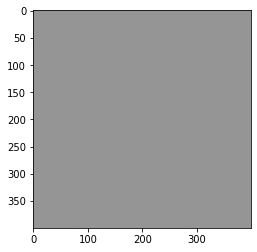

In [3]:
from ex5 import *
import numpy as np
%matplotlib inline

map_size = 100
map_res = 0.25

prior = 0.50
prob_occ = 0.90
prob_free = 0.35

# load data
ranges_raw = np.loadtxt("data/ranges.data", delimiter=',', dtype='float')
poses_raw = np.loadtxt("data/poses.data", delimiter=',', dtype='float')

# initialize gridmap
occ_gridmap = init_gridmap(map_size, map_res)+prior
plot_gridmap(occ_gridmap)

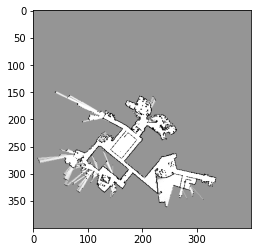

In [4]:
#Grid map output
gridmap = grid_mapping_with_known_poses(ranges_raw, poses_raw, occ_gridmap, map_res, prob_occ, prob_free, prior)

#Plot the grid map
plot_gridmap(gridmap)